# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [254]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [255]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [256]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=69.37549916251339, mobile=True), User(purchased=True, time_on_site=312.8420827093461, mobile=False), User(purchased=True, time_on_site=213.16974024645265, mobile=False), User(purchased=False, time_on_site=251.7120776536217, mobile=True), User(purchased=False, time_on_site=57.30702482005073, mobile=True), User(purchased=False, time_on_site=233.560442970532, mobile=True), User(purchased=True, time_on_site=228.94089074517632, mobile=True), User(purchased=True, time_on_site=263.40581899958227, mobile=True), User(purchased=True, time_on_site=12.788278433302974, mobile=True), User(purchased=False, time_on_site=282.7308174617668, mobile=True)]


In [257]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,69.375499,True
1,True,312.842083,False
2,True,213.169740,False
3,False,251.712078,True
4,False,57.307025,True


In [258]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.287364026556882,5.937587208454312,6.371741157418757,7.456449002515388,7.711372362729771,7.787818305751818,7.998555199210314,8.636077038179128,9.298923900476813,9.35162093413263,...,577.39514463023,579.7620507031057,583.1996615776982,584.7963687465727,587.5560659243263,592.8329184003549,593.181220482993,597.7133981122715,598.7519684052621,598.8680910122499
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,1,1,0,1,1,1,...,1,0,1,1,1,1,1,0,1,1
True,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [259]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.694, 124.004]","(124.004, 242.72]","(242.72, 361.436]","(361.436, 480.152]","(480.152, 598.868]"
purchased,,,,,
False,292,233,130,21,33
True,69,108,71,18,25


In [260]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.694, 124.004]","(124.004, 242.72]","(242.72, 361.436]","(361.436, 480.152]","(480.152, 598.868]"
purchased,,,,,
False,0.808864,0.683284,0.646766,0.538462,0.568966
True,0.191136,0.316716,0.353234,0.461538,0.431034


In [261]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.688,0.716
True,0.312,0.284


In [262]:
# More on binning
pd.cut(user_data['time_on_site'], 5)

0        (4.694, 124.004]
1       (242.72, 361.436]
2       (124.004, 242.72]
3       (242.72, 361.436]
4        (4.694, 124.004]
5       (124.004, 242.72]
6       (124.004, 242.72]
7       (242.72, 361.436]
8        (4.694, 124.004]
9       (242.72, 361.436]
10       (4.694, 124.004]
11       (4.694, 124.004]
12      (124.004, 242.72]
13      (124.004, 242.72]
14      (242.72, 361.436]
15     (361.436, 480.152]
16      (242.72, 361.436]
17       (4.694, 124.004]
18       (4.694, 124.004]
19       (4.694, 124.004]
20      (124.004, 242.72]
21       (4.694, 124.004]
22      (242.72, 361.436]
23      (242.72, 361.436]
24       (4.694, 124.004]
25      (124.004, 242.72]
26       (4.694, 124.004]
27      (242.72, 361.436]
28       (4.694, 124.004]
29       (4.694, 124.004]
              ...        
970    (361.436, 480.152]
971      (4.694, 124.004]
972      (4.694, 124.004]
973      (4.694, 124.004]
974      (4.694, 124.004]
975     (242.72, 361.436]
976      (4.694, 124.004]
977     (124

In [263]:
help(pd.cut)

Help on function cut in module pandas.core.reshape.tile:

cut(x, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False)
    Return indices of half-open bins to which each value of `x` belongs.
    
    Parameters
    ----------
    x : array-like
        Input array to be binned. It has to be 1-dimensional.
    bins : int, sequence of scalars, or IntervalIndex
        If `bins` is an int, it defines the number of equal-width bins in the
        range of `x`. However, in this case, the range of `x` is extended
        by .1% on each side to include the min or max values of `x`. If
        `bins` is a sequence it defines the bin edges allowing for
        non-uniform bin width. No extension of the range of `x` is done in
        this case.
    right : bool, optional
        Indicates whether the bins include the rightmost edge or not. If
        right == True (the default), then the bins [1,2,3,4] indicate
        (1,2], (2,3], (3,4].
    labels : array or boole

In [264]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?
pd.crosstab([user_data['purchased'], time_bins], user_data['mobile'],
            normalize='columns')

mobile                        False     True 
purchased time_on_site                       
False     (4.694, 124.004]    0.228  0.313333
          (124.004, 242.72]   0.108  0.274667
          (242.72, 361.436]   0.136  0.128000
          (361.436, 480.152]  0.084  0.000000
          (480.152, 598.868]  0.132  0.000000
True      (4.694, 124.004]    0.040  0.078667
          (124.004, 242.72]   0.048  0.128000
          (242.72, 361.436]   0.052  0.077333
          (361.436, 480.152]  0.072  0.000000
          (480.152, 598.868]  0.100  0.000000

In [265]:
help(user_data.plot.bar)

Help on method bar in module pandas.plotting._core:

bar(x=None, y=None, **kwds) method of pandas.plotting._core.FramePlotMethods instance
    Vertical bar plot
    
    .. versionadded:: 0.17.0
    
    Parameters
    ----------
    x, y : label or position, optional
        Coordinates for each point.
    **kwds : optional
        Keyword arguments to pass on to :py:meth:`pandas.DataFrame.plot`.
    
    Returns
    -------
    axes : matplotlib.AxesSubplot or np.array of them



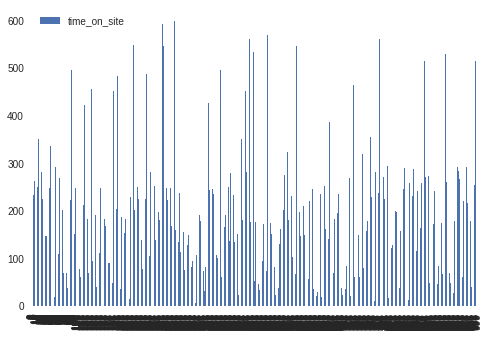

In [266]:
user_data.plot.bar()

In [267]:
# So we have a working barchart method
# Does it just expand our crosstab?
ct = pd.crosstab([user_data['purchased'], time_bins], user_data['mobile'],
                 normalize='columns')
ct

mobile                        False     True 
purchased time_on_site                       
False     (4.694, 124.004]    0.228  0.313333
          (124.004, 242.72]   0.108  0.274667
          (242.72, 361.436]   0.136  0.128000
          (361.436, 480.152]  0.084  0.000000
          (480.152, 598.868]  0.132  0.000000
True      (4.694, 124.004]    0.040  0.078667
          (124.004, 242.72]   0.048  0.128000
          (242.72, 361.436]   0.052  0.077333
          (361.436, 480.152]  0.072  0.000000
          (480.152, 598.868]  0.100  0.000000

In [268]:
dir(ct)

['T',
 '_AXIS_ALIASES',
 '_AXIS_IALIASES',
 '_AXIS_LEN',
 '_AXIS_NAMES',
 '_AXIS_NUMBERS',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_SLICEMAP',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_wrap__',
 '__bool__',
 '__bytes__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',


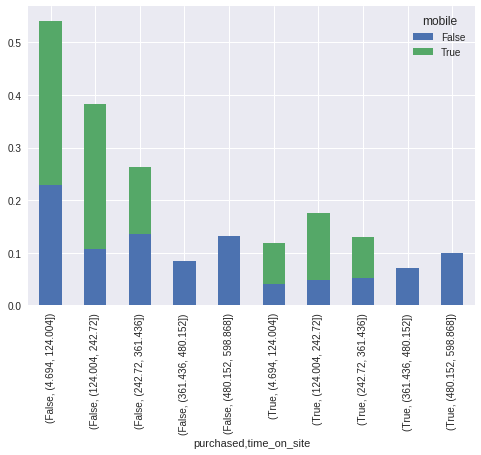

In [269]:
ct.plot(kind='bar', stacked=True)

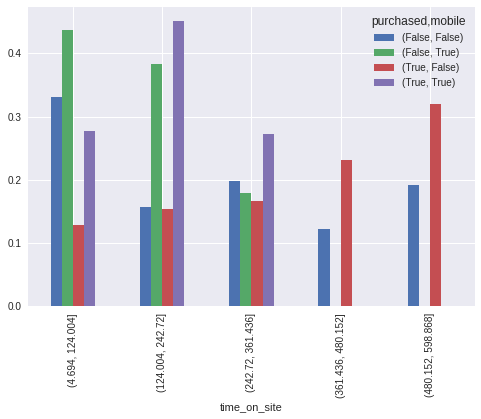

In [270]:
# Courtesy of A
pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
            normalize='columns').plot(kind = 'bar', stacked = False);

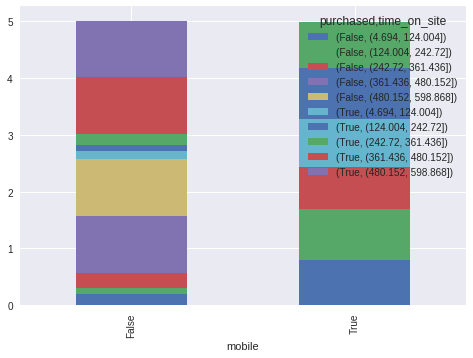

In [271]:
# Starting point for mobile/desktop stacked barcharts
# Probably want to redo with fewer time-bins
pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins],
            normalize='columns').plot(kind = 'bar', stacked = True);

In [272]:
'scatter' in dir(ct.plot)

True

In [0]:
grouped_data = user_data['mobile'].groupby(user_data['purchased'])

In [274]:
dir(grouped_data)

['__bytes__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_accessors',
 '_add_numeric_operations',
 '_agg_doc',
 '_aggregate',
 '_aggregate_multiple_funcs',
 '_aggregate_named',
 '_apply_filter',
 '_apply_to_column_groupbys',
 '_apply_whitelist',
 '_assure_grouper',
 '_builtin_table',
 '_concat_objects',
 '_constructor',
 '_cumcount_array',
 '_cython_agg_general',
 '_cython_table',
 '_cython_transform',
 '_def_str',
 '_deprecations',
 '_dir_additions',
 '_dir_deletions',
 '_get_index',
 '_get_indices',
 '_gotitem',
 '_group_selection',
 '_index_with_as_index',
 '_internal_names',
 '_internal_

In [0]:
# TODO continue exploring grouped_data, grouped_data.plot, etc.

In [276]:
[x for x in dir(ct) if 'add' in x]  # Courtesy of Ryan Herr

['__add__',
 '__iadd__',
 '__radd__',
 '_add_numeric_operations',
 '_add_series_only_operations',
 '_add_series_or_dataframe_operations',
 '_dir_additions',
 'add',
 'add_prefix',
 'add_suffix',
 'radd']

In [277]:
ct_props = dir(ct)
'add' in ct_props

True

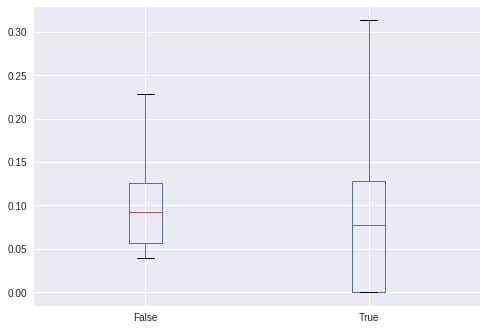

In [278]:
ct.boxplot()

In [279]:
!apt install r-base

Reading package lists... Done
Building dependency tree       
Reading state information... Done
r-base is already the newest version (3.4.4-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [280]:
!R --version

R version 3.4.4 (2018-03-15) -- "Someone to Lean On"
Copyright (C) 2018 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under the terms of the
GNU General Public License versions 2 or 3.
For more information about these matters see
http://www.gnu.org/licenses/.



In [281]:
!pip install rpy2

In [282]:
# Download the data
data_url = 'https://github.com/lockedata/datasauRus/raw/master/data/simpsons_paradox.rda'

!wget $data_url
!ls

--2018-11-09 01:45:29--  https://github.com/lockedata/datasauRus/raw/master/data/simpsons_paradox.rda
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lockedata/datasauRus/master/data/simpsons_paradox.rda [following]
--2018-11-09 01:45:29--  https://raw.githubusercontent.com/lockedata/datasauRus/master/data/simpsons_paradox.rda
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7090 (6.9K) [application/octet-stream]
Saving to: ‘simpsons_paradox.rda.2’

simpsons_paradox.rd 100%[===================>]   6.92K  --.-KB/s    in 0s      

2018-11-09 01:45:29 (73.4 MB/s) - ‘simpsons_paradox.r

In [283]:
!pip install tzlocal

In [284]:
# Trying to load R data in Python
# https://itsalocke.com/datasaurus/reference/simpsons_paradox
# https://stackoverflow.com/questions/40160149/reading-rda-file-in-python-as-a-pandas-data-frame#40161783

import rpy2.robjects as robjects
from rpy2.robjects import default_converter
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
pandas2ri.activate()

# load your file
robjects.r['load']('simpsons_paradox.rda')

# use the default conversion rules to which the pandas conversion
# is added
with localconverter(default_converter + pandas2ri.converter) as cv:
    df = robjects.r["data"]

matrix = robjects.r['data']

matrix

R object with classes: ('function',) mapped to:
<SignatureTranslatedFunction - Python:0x7f8da948d508 / R:0x7f7ad48>

In [0]:
thing = df()

In [286]:
for item in thing.items():
  print(item)

('title', R object with classes: ('character',) mapped to:
<StrVector - Python:0x7f8da8810c08 / R:0x7f9f8f8>
['Data sets'])
('header', rpy2.rinterface.NULL)
('results', R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x7f8da88106c8 / R:0x66f3000>
['datasets', 'datasets', 'datasets', 'datasets', ..., 'Populati..., "Topograp..., 'The Numb..., 'Average ...])
('footer', R object with classes: ('character',) mapped to:
<StrVector - Python:0x7f8da88105c8 / R:0x7a07e98>
['Use ‘data(package = .packages(all.available = TR...])


## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [287]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

persons_df = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv')
persons_df.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [288]:
persons_df.shape

(1200, 4)

In [289]:
# Persons with highest amont of time of weekly exercise - lower weight??
persons_df[persons_df.exercise_time == persons_df.exercise_time.max()]

,Unnamed: 0,age,weight,exercise_time
68,68,55,130,300
225,225,49,128,300
363,363,51,146,300
1044,1044,58,134,300
1126,1126,24,101,300


In [290]:
# Persons with lowest weekly exercise of exercise - higher weight??
persons_df[persons_df.exercise_time == persons_df.exercise_time.min()]

,Unnamed: 0,age,weight,exercise_time
89,89,32,205,0
425,425,20,183,0


In [291]:
# Oldest persons - less exercise? more/less weight??
persons_df[persons_df.age == persons_df.age.max()]

,Unnamed: 0,age,weight,exercise_time
41,41,80,186,87
103,103,80,216,22
116,116,80,170,61
158,158,80,221,67
202,202,80,238,34
270,270,80,212,16
392,392,80,136,43
411,411,80,239,8
538,538,80,168,87
547,547,80,229,27


In [292]:
# Youngest persons - more exercise? less/more weight??
persons_df[persons_df.age == persons_df.age.min()]

,Unnamed: 0,age,weight,exercise_time
18,18,18,122,271
83,83,18,114,104
171,171,18,138,235
203,203,18,120,161
294,294,18,161,85
323,323,18,171,217
372,372,18,184,119
469,469,18,115,243
551,551,18,191,9
573,573,18,188,128


### Doing some basic plotting

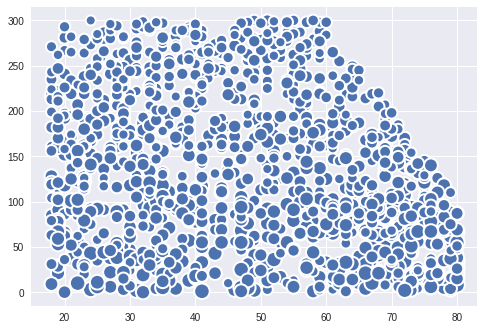

In [293]:
# Scatter plot using all three variables
import matplotlib.pyplot as plt

plt.scatter(persons_df.age, persons_df.exercise_time, s=persons_df.weight, linewidths=2, edgecolor='w')

plt.show()

In [294]:
# Sectioning exercise_time, age, and weigth variables into 6 bins each
timex_bins = pd.cut(persons_df.exercise_time, 5)
age_bins = pd.cut(persons_df.age, 4)
weight_bins = pd.cut(persons_df.weight, 3)

# Creating crosstab
crosst = pd.crosstab(timex_bins, [age_bins, weight_bins], normalize='columns')
crosst

age               (17.938, 33.5]                                      \
weight         (99.854, 148.667] (148.667, 197.333] (197.333, 246.0]   
exercise_time                                                          
(-0.3, 60.0]            0.104651           0.194690         0.666667   
(60.0, 120.0]           0.122093           0.230088         0.250000   
(120.0, 180.0]          0.215116           0.247788         0.083333   
(180.0, 240.0]          0.250000           0.265487         0.000000   
(240.0, 300.0]          0.308140           0.061947         0.000000   

age                 (33.5, 49.0]                                      \
weight         (99.854, 148.667] (148.667, 197.333] (197.333, 246.0]   
exercise_time                                                          
(-0.3, 60.0]            0.115607           0.219780         0.536585   
(60.0, 120.0]           0.150289           0.296703         0.390244   
(120.0, 180.0]          0.138728           0.208791         0.073171   
(180.0, 240.0]          0.242775           0.120879         0.000000   
(240.0, 300.0]          0.352601           0.153846         0.000000   

age                 (49.0, 64.5]                                      \
weight         (99.854, 148.667] (148.667, 197.333] (197.333, 246.0]   
exercise_time                                                          
(-0.3, 60.0]            0.099291           0.210526             0.35   
(60.0, 120.0]           0.113475           0.336842             0.50   
(120.0, 180.0]          0.219858           0.157895             0.15   
(180.0, 240.0]          0.219858           0.231579             0.00   
(240.0, 300.0]          0.347518           0.063158             0.00   

age                 (64.5, 80.0]                                      
weight         (99.854, 148.667] (148.667, 197.333] (197.333, 246.0]  
exercise_time                                                         
(-0.3, 60.0]            0.294643           0.270492         0.593750  
(60.0, 120.0]           0.392857           0.459016         0.359375  
(120.0, 180.0]          0.205357           0.254098         0.046875  
(180.0, 240.0]          0.098214           0.016393         0.000000  
(240.0, 300.0]          0.008929           0.000000         0.000000

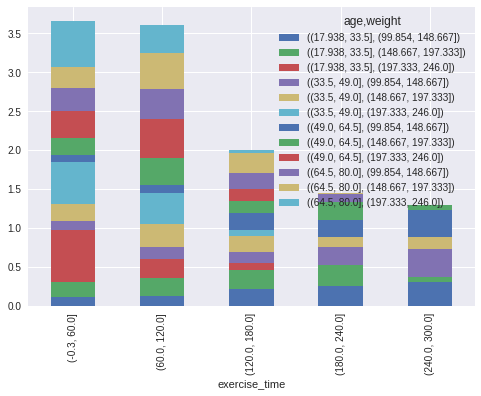

In [295]:
# Stacked bar plot using results from crosstab
crosst.plot(kind='bar', stacked=True);

### Creating a bubble scatter plot

In [296]:
# Cross tab converted to DataFrame to then do bubble plot
ctab = pd.crosstab([age_bins, weight_bins], timex_bins, normalize='columns')
ctab = pd.DataFrame(ctab)
ctab

exercise_time                      (-0.3, 60.0]  (60.0, 120.0]  \
age            weight                                            
(17.938, 33.5] (99.854, 148.667]       0.064748       0.066456   
               (148.667, 197.333]      0.079137       0.082278   
               (197.333, 246.0]        0.086331       0.028481   
(33.5, 49.0]   (99.854, 148.667]       0.071942       0.082278   
               (148.667, 197.333]      0.071942       0.085443   
               (197.333, 246.0]        0.079137       0.050633   
(49.0, 64.5]   (99.854, 148.667]       0.050360       0.050633   
               (148.667, 197.333]      0.071942       0.101266   
               (197.333, 246.0]        0.050360       0.063291   
(64.5, 80.0]   (99.854, 148.667]       0.118705       0.139241   
               (148.667, 197.333]      0.118705       0.177215   
               (197.333, 246.0]        0.136691       0.072785   

exercise_time                      (120.0, 180.0]  (180.0, 240.0]  \
age            weight                                               
(17.938, 33.5] (99.854, 148.667]         0.165919        0.223958   
               (148.667, 197.333]        0.125561        0.156250   
               (197.333, 246.0]          0.013453        0.000000   
(33.5, 49.0]   (99.854, 148.667]         0.107623        0.218750   
               (148.667, 197.333]        0.085202        0.057292   
               (197.333, 246.0]          0.013453        0.000000   
(49.0, 64.5]   (99.854, 148.667]         0.139013        0.161458   
               (148.667, 197.333]        0.067265        0.114583   
               (197.333, 246.0]          0.026906        0.000000   
(64.5, 80.0]   (99.854, 148.667]         0.103139        0.057292   
               (148.667, 197.333]        0.139013        0.010417   
               (197.333, 246.0]          0.013453        0.000000   

exercise_time                      (240.0, 300.0]  
age            weight                              
(17.938, 33.5] (99.854, 148.667]         0.277487  
               (148.667, 197.333]        0.036649  
               (197.333, 246.0]          0.000000  
(33.5, 49.0]   (99.854, 148.667]         0.319372  
               (148.667, 197.333]        0.073298  
               (197.333, 246.0]          0.000000  
(49.0, 64.5]   (99.854, 148.667]         0.256545  
               (148.667, 197.333]        0.031414  
               (197.333, 246.0]          0.000000  
(64.5, 80.0]   (99.854, 148.667]         0.005236  
               (148.667, 197.333]        0.000000  
               (197.333, 246.0]          0.000000

In [0]:
# Removing Categorical Index on sides
ctab = ctab.reset_index(0, 1).reset_index(drop=True)

In [0]:
# Converting columns from 'Interval' datatype to string
ctab.columns = ctab.columns.astype(str)

In [0]:
# Flattening hirarchical index in columns
# So we can then insert columns with 'age' and 'weight'
ctab.columns = [''.join(col).strip() for col in ctab.columns.values]

In [300]:
# Modifying column names
ctab.columns = ['0-60min', '60-120min', '120-180min',
                '180-240min', '240-300min']

# Inserting 'age' and 'weight' columns with values
ctab['age'] = ['17 to 33', '17 to 33', '17 to 33', '34 to 48', '34 to 48',
               '34 to 48', '49 to 64', '49 to 64', '49 to 64', '65 to 80',
               '65 to 80', '65 to 80']
ctab['weight'] = ['99 to 148', '149 to 196', '197 to 246', '99 to 148',
                  '149 to 196', '197 to 246', '99 to 148', '149 to 196',
                  '197 to 246', '99 to 148', '149 to 196', '197 to 246']

ctab

,0-60min,60-120min,120-180min,180-240min,240-300min,age,weight
0,0.064748,0.066456,0.165919,0.223958,0.277487,17 to 33,99 to 148
1,0.079137,0.082278,0.125561,0.156250,0.036649,17 to 33,149 to 196
2,0.086331,0.028481,0.013453,0.000000,0.000000,17 to 33,197 to 246
3,0.071942,0.082278,0.107623,0.218750,0.319372,34 to 48,99 to 148
4,0.071942,0.085443,0.085202,0.057292,0.073298,34 to 48,149 to 196
5,0.079137,0.050633,0.013453,0.000000,0.000000,34 to 48,197 to 246
6,0.050360,0.050633,0.139013,0.161458,0.256545,49 to 64,99 to 148
7,0.071942,0.101266,0.067265,0.114583,0.031414,49 to 64,149 to 196
8,0.050360,0.063291,0.026906,0.000000,0.000000,49 to 64,197 to 246
9,0.118705,0.139241,0.103139,0.057292,0.005236,65 to 80,99 to 148


In [0]:
# Changed order of columns
ctab = ctab[[ 'age', 'weight', '0-60min', '60-120min', '120-180min',
             '180-240min', '240-300min']]

In [302]:
ctab

,age,weight,0-60min,60-120min,120-180min,180-240min,240-300min
0,17 to 33,99 to 148,0.064748,0.066456,0.165919,0.223958,0.277487
1,17 to 33,149 to 196,0.079137,0.082278,0.125561,0.156250,0.036649
2,17 to 33,197 to 246,0.086331,0.028481,0.013453,0.000000,0.000000
3,34 to 48,99 to 148,0.071942,0.082278,0.107623,0.218750,0.319372
4,34 to 48,149 to 196,0.071942,0.085443,0.085202,0.057292,0.073298
5,34 to 48,197 to 246,0.079137,0.050633,0.013453,0.000000,0.000000
6,49 to 64,99 to 148,0.050360,0.050633,0.139013,0.161458,0.256545
7,49 to 64,149 to 196,0.071942,0.101266,0.067265,0.114583,0.031414
8,49 to 64,197 to 246,0.050360,0.063291,0.026906,0.000000,0.000000
9,65 to 80,99 to 148,0.118705,0.139241,0.103139,0.057292,0.005236


### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
>There are three variables (age, weight, and exercise time). All are continuos numerical variables that we then changed to discrete ordinal variables after performing cross tabulation
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)